# Thông tin nhóm
Thành viên:
* Đặng Thái Duy - 19120491
* Hà Chí Hào - 19120219
* Mai Duy Nam - 19120298
* Trần Phương Đình - 19120476

# Import thư viện

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time

# Cài đặt thuật toán

## Không sử dụng vectorization

In [2]:
def levenshtein_distance(a: str, b: str) -> int:
    m, n = len(a), len(b)
    d = np.zeros((m+1, n+1), dtype=int)

    for i in range(m+1):
      d[i, 0] = i
    for i in range(n+1):
      d[0, i] = i
    
    for j in range(1, n+1):
        for i in range(1, m+1):
            cost = 1 if a[i-1] != b[j-1] else 0
            d[i, j] = min(d[i-1, j-1] + cost,   # substitute
                          d[i, j-1]   + 1,      # insert
                          d[i-1, j]   + 1)      # delete
    return d[m, n]

## Có sử dụng vectorization

Thay vì tìm khoảng cách Levenshtein từ một chuỗi a (độ dài $m$) đến một chuỗi b (độ dài $n$), hàm dưới đây tìm khoảng cách Levenshtein từ chuỗi a đến $k$ chuỗi có cùng độ dài là $n$ như vậy. Nghĩa là, ta tìm $k$ khoảng cách Levenshtein từ a đến $k$ chuỗi có cùng độ dài $n$.

Ta gom $k$ chuỗi có độ dài $n$ đó thành một ma trận kích thước $n \times k$ và tận dụng kỹ thuật broadcast của NumPy để tính nhiều khoảng cách Levenshtein cùng lúc.

In [3]:
def levenshtein_distance_vec(a: np.array, b: np.array):
    m, n, k = len(a), len(b), b.shape[1]
    d = np.zeros((m+1, n+1, k), dtype=np.uint16)

    for i in range(m+1):
        d[i, 0] = i
    for i in range(n+1):
        d[0, i] = i
    
    for j in range(1, n+1):
        for i in range(1, m+1):
            cost = a[i-1] != b[j-1]
            d[i, j] = np.min([d[i-1, j-1] + cost,
                              d[i, j-1]   + 1,
                              d[i-1, j]   + 1], axis=0)

    return d[m, n]

# Đo thời gian chạy

## Chạy trên một cặp chuỗi

In [4]:
query_text =  'ho chiminj'
target_text = 'ho chi minh'

print('Testing Levenshtein distance')
%time levenshtein_distance_result = levenshtein_distance(query_text, target_text)
print(f'Distance: {levenshtein_distance_result}')

Testing Levenshtein distance
Wall time: 0 ns
Distance: 2


## Chạy trên tập dữ liệu có nhiều chuỗi

### Tải dữ liệu

In [39]:
df = pd.read_csv("Data/data.csv")
df.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6839,139.7744,Japan,JP,JPN,Tōkyō,primary,39105000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,35362000.0,1360771077
2,Delhi,Delhi,28.6667,77.2167,India,IN,IND,Delhi,admin,31870000.0,1356872604
3,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23971000.0,1608618140
4,São Paulo,Sao Paulo,-23.5504,-46.6339,Brazil,BR,BRA,São Paulo,admin,22495000.0,1076532519


In [11]:
cities = df["city_ascii"].apply(lambda x: x.lower()).unique()
print(cities)
print(cities.size)

['tokyo' 'jakarta' 'delhi' ... 'nord' 'timmiarmiut' 'nordvik']
39186


### Levenshtein distance không sử dụng vectorization

In [15]:
def levenshtein_find(query_text, texts):
  best_score = -np.inf
  best_result = ''

  for text in texts:
    if len(text) == 0:
      continue
    
    text = text.lower()
    d = levenshtein_distance(query_text, text)
    score = 1.0 - d / max(len(query_text), len(text))
    
    if score > best_score:
      best_score = score
      best_result = text

  return (best_score, best_result)

In [13]:
%%time
levenshtein_find('ho chiminj', cities)

Wall time: 4.71 s


(0.5625, 'ho chi minh city')

In [14]:
%%time
levenshtein_find('hanpi', cities)

Wall time: 2.46 s


(0.8, 'hanoi')

### Đo thời gian chạy với một số query khác nhau

In [16]:
keywords = ['ho chiminj', 'hanpi', 'danang', 'daklk']
runs = 3
results = []
for keyword in keywords:
    run_times = []
    best_match = None
    for _ in range(runs):
        start = time.time()
        best_match = levenshtein_find(keyword, cities)[1]
        end = time.time()
        run_times.append(end - start)

    results.append([keyword] + run_times + [best_match])

In [17]:
test_queries = pd.DataFrame(results)
test_queries.columns = ['query', 'run_1', 'run_2', 'run_3', 'result']
test_queries

,query,run_1,run_2,run_3,result
0,ho chiminj,4.586443,4.598561,4.545436,ho chi minh city
1,hanpi,2.345913,2.370579,2.416398,hanoi
2,danang,2.800533,2.748364,2.813193,danyang
3,daklk,2.421452,2.393297,2.397267,dakar


8 kết quả tốt nhất khi search với query "danang".

In [18]:
danang_search_result = []
for c in cities:
    d = levenshtein_distance('danang', c)
    score = 1.0 - d / max(len('danang'), len(c))
    danang_search_result.append([score, c])
danang_search_result = pd.DataFrame(danang_search_result)
danang_search_result.columns = ['score', 'city']
danang_search_result = danang_search_result.sort_values(by='score', ascending=False)
danang_search_result[:8]

,score,city
7965,0.857143,da nang
851,0.857143,danyang
1967,0.833333,datang
1262,0.750000,dangyang
320,0.714286,dandong
380,0.714286,kananga
12667,0.714286,daxiang
24615,0.714286,kantang


### Kiểm tra thời gian chạy của thuật toán có đúng là $O(znm)$ hay không

Với $z$ là số lượng chuỗi trong tập dữ liệu, $n$ là độ dài của chuỗi query, $m$ là độ dài trung bình của các chuỗi trong tập dữ liệu.

#### Khảo sát sự phụ thuộc của thời gian chạy vào $z$

In [19]:
def test_set_size(query, texts, runs=3):
    set_sizes = []
    query_times = []

    for length in np.arange(0, len(texts), 1000, dtype=int):
        set_sizes.append(length)
        run_times = []
        for _ in range(runs):
            subset = np.random.choice(texts, length)
            start = time.time()
            levenshtein_find(query, subset)
            end = time.time()
            run_times.append(end - start)
        
        query_times.append(run_times)
    return set_sizes, query_times

In [20]:
%%time
np.random.seed(2)
set_sizes, query_times = test_set_size('ho chi minh', cities)

Wall time: 5min 18s


In [21]:
columns = [f'run_{i+1}' for i in range(len(query_times[0]))]
times_by_set_sizes_df = pd.DataFrame(
    data=query_times,
    columns=columns,
    index=set_sizes
)
times_by_set_sizes_df.index.name = 'set_size'
times_by_set_sizes_df

,run_1,run_2,run_3
set_size,,,
0,0.000000,0.000000,0.000000
1000,0.141622,0.127844,0.120375
2000,0.243856,0.248337,0.252292
3000,0.380522,0.397522,0.408551
4000,0.518614,0.582462,0.520167
5000,0.657710,0.630080,0.622334
6000,0.747707,0.809854,0.770411
7000,0.903145,0.867600,0.921068
8000,1.055844,1.322233,1.082006


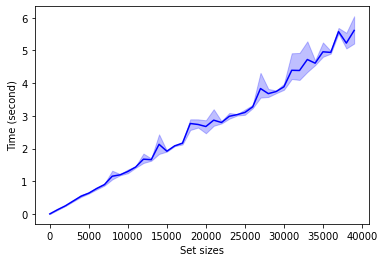

In [22]:
plt.plot(times_by_set_sizes_df.index, times_by_set_sizes_df.mean(axis=1), color='blue')
plt.fill_between(
    times_by_set_sizes_df.index,
    times_by_set_sizes_df.min(axis=1),
    times_by_set_sizes_df.max(axis=1),
    alpha=0.25,
    color='blue'
)
plt.xlabel('Set sizes')
plt.ylabel('Time (second)')
plt.show()

#### Khảo sát sự phụ thuộc của thời gian chạy vào $n$

In [23]:
def random_ascii_text(length):
    result = [random.randrange(26, 52) for _ in range(length)]
    result = ''.join([chr(c) for c in result])
    return result

In [24]:
def test_query_length(texts, runs=3):
    query_lengths = []
    query_times = []

    for length in np.arange(1, 11) * 5:
        query_lengths.append(length)

        run_times = []
        for _ in range(runs):
            query = random_ascii_text(length)

            start = time.time()
            levenshtein_find(query, cities)
            end = time.time()
            run_times.append(end - start)
    
        query_times.append(run_times)

    return query_lengths, query_times

In [25]:
%%time
query_lengths, query_times = test_query_length(cities, runs=3)

Wall time: 6min 10s


In [26]:
columns = [f'run_{i+1}' for i in range(len(query_times[0]))]
times_by_query_lengths_df = pd.DataFrame(
    data=query_times,
    columns=columns,
    index=query_lengths
)
times_by_query_lengths_df.index.name = 'query_length'
times_by_query_lengths_df

,run_1,run_2,run_3
query_length,,,
5,2.424863,2.558958,2.377103
10,4.489279,4.571560,4.609208
15,6.717135,6.587432,6.909945
20,8.843894,8.725994,8.857941
25,11.423391,11.426773,11.321968
30,13.547571,13.248183,13.871455
35,15.949310,15.779856,16.777119
40,18.215074,18.532459,17.281274
45,19.582400,19.945338,20.034613


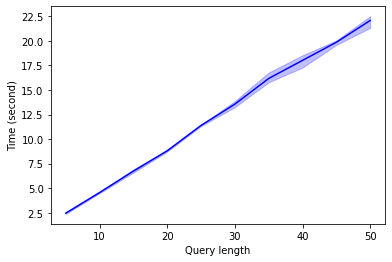

In [27]:
plt.plot(times_by_query_lengths_df.index, times_by_query_lengths_df.mean(axis=1), color='blue')
plt.fill_between(
    times_by_query_lengths_df.index,
    times_by_query_lengths_df.min(axis=1),
    times_by_query_lengths_df.max(axis=1),
    alpha=0.25,
    color='blue'
)
plt.xlabel('Query length')
plt.ylabel('Time (second)')
plt.show()

#### Khảo sát sự phụ thuộc của thời gian chạy vào $m$

In [28]:
def test_m(query, size, runs=3):
    ms = []
    results = []
    for m in np.arange(1, 11) * 5:
        ms.append(m)
        run_times = []
        for _ in range(runs):
            texts = [random_ascii_text(m) for _ in range(size)]
            start = time.time()
            levenshtein_find(query, texts)
            end = time.time()
            run_times.append(end - start)
        results.append(run_times)
    return ms, results

In [29]:
%%time
ms, results = test_m('ha noi', 500)

Wall time: 3.34 s


In [30]:
columns = [f'run_{i+1}' for i in range(len(results[0]))]
times_by_mean_text_lengths_df = pd.DataFrame(
    data=results,
    columns=columns,
    index=ms
)
times_by_mean_text_lengths_df.index.name = 'mean_text_length'
times_by_mean_text_lengths_df

,run_1,run_2,run_3
mean_text_length,,,
5,0.019947,0.020941,0.019556
10,0.038951,0.037241,0.036562
15,0.055092,0.065800,0.064826
20,0.074834,0.071434,0.073771
25,0.088412,0.088760,0.090338
30,0.109710,0.106222,0.107724
35,0.123093,0.121863,0.122672
40,0.140864,0.187774,0.148314
45,0.161373,0.172923,0.167996


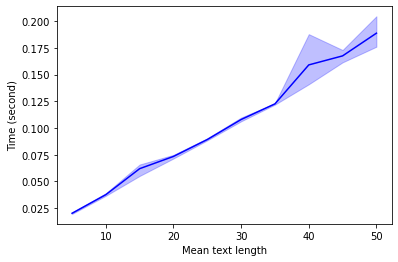

In [31]:
plt.plot(times_by_mean_text_lengths_df.index, times_by_mean_text_lengths_df.mean(axis=1), color='blue')
plt.fill_between(
    times_by_mean_text_lengths_df.index,
    times_by_mean_text_lengths_df.min(axis=1),
    times_by_mean_text_lengths_df.max(axis=1),
    alpha=0.25,
    color='blue'
)
plt.xlabel('Mean text length')
plt.ylabel('Time (second)')
plt.show()

### Levenshtein distance có sử dụng vectorization

In [32]:
def texts_to_dict(texts):
    len_to_texts = {}
    for word in texts:
        len_to_texts.setdefault(len(word), []).append(word)

    for n, words in len_to_texts.items():
        mat = [[ord(c) for c in word.lower()] for word in words]
        mat = np.asarray(mat).T
        len_to_texts[n] = mat

    return len_to_texts

In [33]:
len_to_texts = texts_to_dict(cities)
len_to_texts[23]

array([[ 99, 103,  99, ..., 108, 115,  99],
       [105, 101,  97, ...,  97,  97,  97],
       [117, 110,  99, ...,  32, 105, 112],
       ...,
       [101, 114, 114, ..., 105, 122, 110],
       [100, 101, 105, ..., 101, 111, 122],
       [111, 122, 109, ..., 108, 110,  97]])

In [34]:
def levenshtein_vec_find(query_text, len_to_texts):
    best_score = -np.inf
    best_result = None

    # Turn the query text into np.array
    text = np.asarray([ord(c) for c in query_text])

    for length, mat in len_to_texts.items():
        distances = levenshtein_distance_vec(text, mat)
        
        best_idx = np.argmin(distances) 
        d = distances[best_idx]
        score = 1.0 - d / max(len(text), length)

        if score > best_score:
            best_score = score
            best_result = (length, best_idx)

    # Convert best match from integers to string
    best_result = len_to_texts[best_result[0]][:, best_result[1]]
    best_result = ''.join([chr(c) for c in best_result])

    return (best_score, best_result)

In [35]:
%%time
levenshtein_vec_find('ho chiminj', len_to_texts)

Wall time: 160 ms


(0.5625, 'ho chi minh city')

#### Search bar đơn giản

In [36]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [37]:
interact(levenshtein_vec_find, query_text='', len_to_texts=fixed(len_to_texts));

interactive(children=(Text(value='', description='query_text'), Output()), _dom_classes=('widget-interact',))

# Xuất số liệu ra file

In [38]:
test_queries.to_csv('Data/test_queries.csv')
danang_search_result.to_csv('Data/danang_search_result.csv')
times_by_set_sizes_df.to_csv('Data/times_by_set_sizes.csv')
times_by_query_lengths_df.to_csv('Data/times_by_query_lengths.csv')
times_by_mean_text_lengths_df.to_csv('Data/times_by_mean_text_lengths.csv')